In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy import ndimage
import pylab as pl
from matplotlib import collections  as mc
import time


In [2]:
def show_match(templates,img):
    fig,axs = plt.subplots(2,4)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    available_placements =[]
    start = time.time()
    for ti,ax in zip(range(len(templates)),axs.ravel()):
    #for ti in range(len(small_t_templates)):
        current = templates[ti]
        edges = cv.Canny(current*255,100,200)
        image = cv.Canny(img*255,100,200)

        h, w = current.shape[:2]

        method = cv.TM_SQDIFF



        res = cv.matchTemplate(image, edges, method, mask=  current)

        i=0
        attempt =0
        while i < 4 and attempt < 10:
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

            xt = min_loc[1]-h//2 if min_loc[1]>20 else 0
            xb = min_loc[1]+h//2+1
            yl = min_loc[0]-w//2 if min_loc[0]>20 else 0
            yr = min_loc[0]+w//2+1

            res[xt:xb,yl:yr] = float('inf')

            central_coord = (min_loc[1]+h//2,min_loc[0]+w//2)
            if (img[central_coord] ==1):
                #print((min_loc[1]+h//2,min_loc[0]+w//2))
                cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )


                available_placements.append((central_coord,ti*45))
                i+=1
            ax.imshow(image,cmap='gray')
            attempt+=1
    print(time.time()-start)
    print(available_placements)

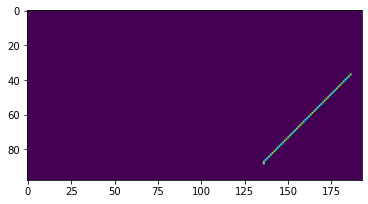

In [29]:
img = cv.imread('./../utility_pictures/thresholded.png',0)
img = img [:,:450]
plt.imshow(img)
edged_img = cv.Canny(img,100,200)
plt.imshow(edged_img)
min_loc =(0, 150)
part =  img[min_loc[1]:min_loc[1]+h,min_loc[0]:min_loc[0]+w]
plt.imshow(part)

(0, 0)
(48, 0)
(96, 0)
(144, 0)
(192, 0)
(240, 0)
(288, 0)
(336, 0)
(0, 25)
(48, 25)
0.008949041366577148
[]


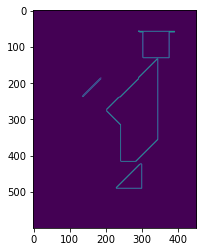

In [30]:
#img = cv.imread('./../puzzle_state.png',0)
#img = cv.imread('./example_pictures/from_app.png',0)
img = cv.imread('./../utility_pictures/thresholded.png',0)
#trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
#img = img[31:-1,1:-1]
#img[500:,:] = 0
img = img [:,:450]
plt.imshow(img*255,cmap = 'gray')
img.shape

##templates
name = 'smallt'
template = cv.imread(f"./tans/{name}.png",0)
template = template[3:,3:]
t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)
plt.imshow(template*255,cmap='gray')

nonzero = template.nonzero()
templates = [template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]]
for r in range(-45,-325,-45):
    rotated= ndimage.rotate(template,r)
    nonzero = rotated.nonzero()
    rotated= rotated[min(nonzero[0])-2:max(nonzero[0])+2,min(nonzero[1])-2:max(nonzero[1])+2]
    templates.append(rotated)

available_placements =[]
start = time.time()
current = templates[0]
edges = cv.Canny(current*255,100,200)

#edged_img = cv.Canny(img*255,100,200)
edged_img = cv.Canny(img,100,200)
image = cv.Canny(img*255,100,200)

h, w = current.shape[:2]

method = cv.TM_SQDIFF

#res = cv.matchTemplate(image, edges, method, mask=  current)
res = cv.matchTemplate(image, edges, method)

i=0
attempt =0
while i < 4 and attempt < 10:
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    xt = min_loc[1]-h//2 if min_loc[1]>20 else 0
    xb = min_loc[1]+h//2+1
    yl = min_loc[0]-w//2 if min_loc[0]>20 else 0
    yr = min_loc[0]+w//2+1

    res[xt:xb,yl:yr] = float('inf')

    central_coord = (min_loc[1]+h//2,min_loc[0]+w//2)
#     if (img[central_coord] ==1):
#         #print((min_loc[1]+h//2,min_loc[0]+w//2))
#         cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )
    print(min_loc)
    part =  img[min_loc[1]:min_loc[1]+h,min_loc[0]:min_loc[0]+w]
    #print(np.count_nonzero(np.bitwise_and(part,current)-current))
    if np.count_nonzero(np.bitwise_and(part,current)-current) <100 :
        
        cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )

        #available_placements.append((central_coord,ti*45))
        available_placements.append(min_loc)
        i+=1
    #ax.imshow(image,cmap='gray')
    attempt+=1
print(time.time()-start)
print(available_placements)
plt.imshow(edged_img)

441


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2389bf74e80>)

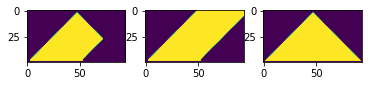

In [5]:
min_loc =(133, 191)
part = img[min_loc[1]:min_loc[1]+h,min_loc[0]:min_loc[0]+w]

print(np.count_nonzero(np.bitwise_and(part,current)-current))

plt.subplot(131),plt.imshow(np.bitwise_and(part,current)*255)
plt.subplot(132),plt.imshow(part)
plt.subplot(133),plt.imshow(current)

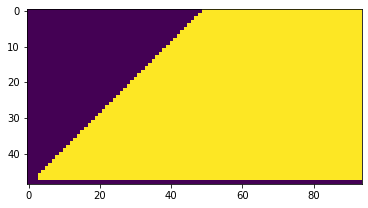

(600, 450)

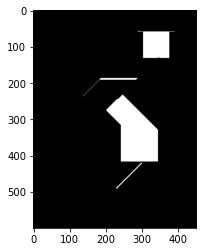

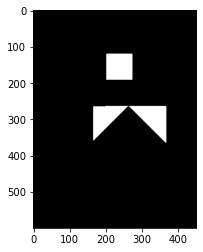

In [54]:
img = cv.imread('./../utility_pictures/thresholded.png',0)
trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
plt.imshow(img*255,cmap = 'gray')
img.shape

##templates
name = 'middlet'
template = cv.imread(f"./tans/{name}.png",0)
template = template[3:,3:]
t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)


nonzero = template.nonzero()
small_t_templates = [template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]]
for r in range(-45,-325,-45):
    rotated= ndimage.rotate(template,r)
    nonzero = rotated.nonzero()
    rotated= rotated[min(nonzero[0])-2:max(nonzero[0])+2,min(nonzero[1])-2:max(nonzero[1])+2]
    small_t_templates.append(rotated)


0.17752504348754883
[((310, 309), 45), ((313, 211), 315)]


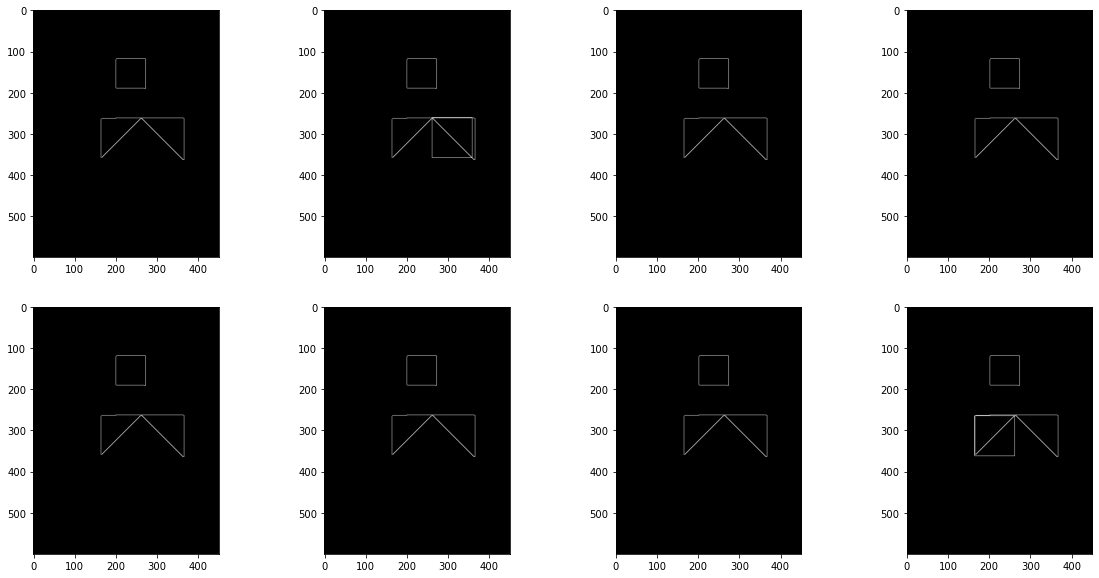

In [55]:
fig,axs = plt.subplots(2,4)
fig.set_figheight(10)
fig.set_figwidth(20)
available_placements =[]
start = time.time()
for ti,ax in zip(range(len(small_t_templates)),axs.ravel()):
#for ti in range(len(small_t_templates)):
    current = small_t_templates[ti]
    edges = cv.Canny(current*255,100,200)
    image = cv.Canny(img*255,100,200)

    h, w = current.shape[:2]

    method = cv.TM_SQDIFF



    #res = cv.matchTemplate(image, edges, method, mask=  current)    
    res = cv.matchTemplate(image, edges, method)
    
    i=0
    attempt =0
    while i < 4 and attempt < 10:
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
        xt = min_loc[1]-h//2 if min_loc[1]>20 else 0
        xb = min_loc[1]+h//2+1
        yl = min_loc[0]-w//2 if min_loc[0]>20 else 0
        yr = min_loc[0]+w//2+1
        
        res[xt:xb,yl:yr] = float('inf')
        
        central_coord = (min_loc[1]+h//2,min_loc[0]+w//2)
#         if (img[central_coord] ==1):
#             #print((min_loc[1]+h//2,min_loc[0]+w//2))
#             cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )
        part =  img[min_loc[1]:min_loc[1]+h,min_loc[0]:min_loc[0]+w]
        if np.count_nonzero(np.bitwise_xor(np.bitwise_and(part,current),current)) <50 :

            cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )

                
            available_placements.append((central_coord,ti*45))
            i+=1
        ax.imshow(image,cmap='gray')
        attempt+=1
print(time.time()-start)
print(available_placements)

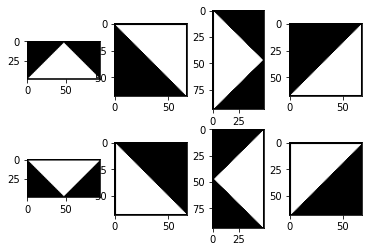

In [46]:
fig,axs = plt.subplots(2,4)
for ti,ax in zip(range(len(small_t_templates)),axs.ravel()):
    ax.imshow(small_t_templates[ti],cmap='gray')

65025.0
(305, 63)
65025.0
(274, 348)
4356675.0
(233, 60)


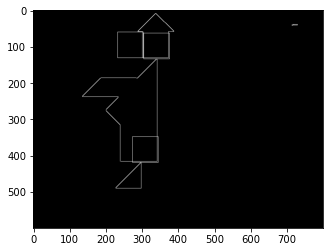

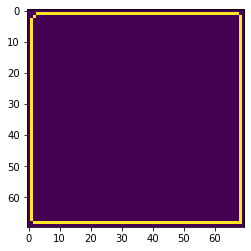

In [64]:
name = 'square'
template = cv.imread(f"./tans/{name}.png",0)
t2,template = cv.threshold(template, 100,1, cv.THRESH_BINARY)
plt.imshow(template*255,cmap='gray')

nonzero = template.nonzero()
current = template[min(nonzero[0]) - 2:max(nonzero[0]) + 2, min(nonzero[1]) - 2:max(nonzero[1]) + 2]
#current = template
edges = cv.Canny(current*255,100,200)
img = cv.imread('./example_pictures/1.png',0)
trhesh,img = cv.threshold(img, 240,1, cv.THRESH_BINARY)
img = img[31:-1,1:-1]
img[500:,:] = 0
image = cv.Canny(img*255,100,200)
#
#image =img.copy()

h, w = current.shape[:2]

method = cv.TM_SQDIFF



res = cv.matchTemplate(image, edges, method, mask=  current)
#res = cv.matchTemplate(image, current, method)
# fake out max_val for first run through loop
min_val = 1
for i in range(3):
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    print(min_val)
    print(min_loc)
         
    xt = min_loc[1]-h//2 if min_loc[1]>20 else 0
    xb = min_loc[1]+h//2+1
    yl = min_loc[0]-w//2 if min_loc[0]>20 else 0
    yr = min_loc[0]+w//2+1
    #res[max_loc[1]-h//2:max_loc[1]+h//2+1, max_loc[0]-w//2:max_loc[0]+w//2+1] = 0 
    res[xt:xb,yl:yr] = float('inf') 
    cv.rectangle(image,(min_loc[0],min_loc[1]), (min_loc[0]+w+1, min_loc[1]+h+1), 255 )
        

plt.figure(0)
plt.imshow(image,cmap='gray')
plt.figure(1)
plt.imshow(edges)

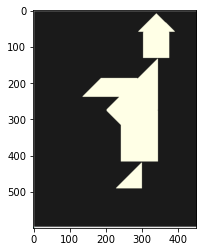

In [5]:
grid_img = plt.imread('./example_pictures/puzzle_state_start.png',0)
grid_img = grid_img[:,:450]
plt.imshow(grid_img)

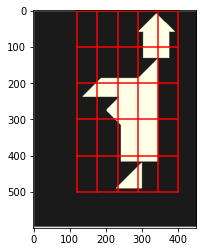

In [18]:
sl = [(-280,0),(-200,300)]
cmin = 120
cmax= 400
rmin = 0
rmax = 500
plt.imshow(grid_img)
for i in range(6):
    plt.plot([cmin+i*56,cmin+i*56],[0,500],'r')
for j in range(6):
    plt.plot([cmin,cmax],[0+j*100,0+j*100],'r')
    

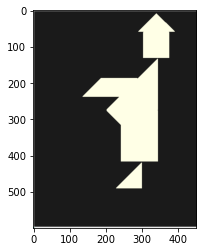

In [28]:
grid_img = plt.imread('./example_pictures/puzzle_state_start.png',0)
grid_img = grid_img[:,:450]
for i in range(6):
    #plt.plot([cmin+i*56,cmin+i*56],[0,500],'r')
    cv.line(grid_img,[cmin+i*56,0],[cmin+i*56,0],color = (0.5))
# for j in range(6):
#     plt.plot([cmin,cmax],[0+j*100,0+j*100],'r')
plt.imshow(grid_img)

In [ ]:
p